# Sprint 13: Supervised learning - classification

#### Imports

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [50]:
df = pd.read_csv("DelayedFlights.csv")
df.head(3)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

## Level 1

### Exercise 1

##### Create 3 different models of classification for prediction of ArrDelay

I will create model to predict if there will be an arrival delay for one airline and one destination.
- First select destination to Las Vegas - code LAS
- Second select the most frequent airline Southwest Airlines - code WN
- Consider if the flight arrived late or not ArrDelay > 0

In [75]:
#retrieve the data
a = df.loc[df['Dest'] == 'LAS']
b = a.loc[df['UniqueCarrier'] == 'WN']
df_flights = b[['Year', 'Month', 'DayofMonth', 'DayOfWeek',
                'CRSArrTime','CRSElapsedTime','ArrDelay',
                'DepDelay','TaxiIn', 'TaxiOut','Cancelled']]
df_flights.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Cancelled
5,2008,1,3,4,1940,250.0,57.0,67.0,3.0,7.0,0
243,2008,1,3,4,1530,65.0,24.0,36.0,4.0,8.0,0
244,2008,1,3,4,1240,65.0,33.0,30.0,3.0,18.0,0


In [76]:
#deleting rows with cancelled flights
df_flights = df_flights.loc[df_flights['Cancelled'] == 0]
df_flights.drop('Cancelled',axis=1, inplace=True)
df_flights.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut
5,2008,1,3,4,1940,250.0,57.0,67.0,3.0,7.0
243,2008,1,3,4,1530,65.0,24.0,36.0,4.0,8.0
244,2008,1,3,4,1240,65.0,33.0,30.0,3.0,18.0


In [77]:
#arrdelay > 0 or not? 1-yes, 0-not
df_flights['Label'] = np.where(df_flights['ArrDelay'] > 0, 1, 0)
df_flights.reset_index(inplace=True,drop=True)
df_flights.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
0,2008,1,3,4,1940,250.0,57.0,67.0,3.0,7.0,1
1,2008,1,3,4,1530,65.0,24.0,36.0,4.0,8.0,1
2,2008,1,3,4,1240,65.0,33.0,30.0,3.0,18.0,1


In [78]:
df_flights.shape

(25226, 11)

In [79]:
#Do I have complete values dataset? how many NaN values I have?
df_flights.isnull().sum()

Year                0
Month               0
DayofMonth          0
DayOfWeek           0
CRSArrTime          0
CRSElapsedTime      0
ArrDelay          138
DepDelay            0
TaxiIn            135
TaxiOut             0
Label               0
dtype: int64

In [80]:
#arithmetic mean for missing values
df_flights['ArrDelay']=df_flights['ArrDelay'].fillna(df_flights['ArrDelay'].mean())
df_flights['TaxiIn']=df_flights['TaxiIn'].fillna(df_flights['TaxiIn'].mean())

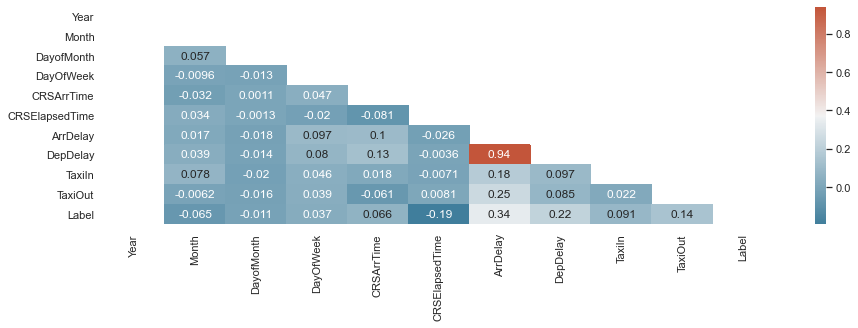

In [81]:
#Correlation matrix - ajusting input values acording this map -  better not to get high correlations
fig,ax = plt.subplots(figsize=(15,4))
corr = df_flights.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

#### Train and test samples

I will work with stratified random sample to have all values proportionaly included (ArrDelay=0, ArrDelay=1).

In [82]:
#stratified random sample - take 50 flights with delay and 50 with no delay
group1 = df_flights[df_flights['Label'] == 0]
group2 = df_flights[df_flights['Label'] == 1]
flights_df1 = group1.sample(n = 100)
flights_df2 = group2.sample(n = 100)
df_flights_sample = flights_df1.append((flights_df2),ignore_index = True)
df_flights_sample.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
0,2008,12,23,2,1125,255.0,-4.0,6.0,3.0,9.0,0
1,2008,9,29,1,1700,130.0,-1.0,6.0,8.0,8.0,0
2,2008,7,1,2,1825,230.0,-13.0,8.0,5.0,8.0,0


In [83]:
X = df_flights_sample.drop('Label',axis=1)
y = df_flights_sample['Label']
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [84]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(140, 10) (140,) (60, 10) (60,)


In [85]:
#scaling the values
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Decision tree classifier

In [180]:
model1 = DecisionTreeClassifier(criterion='gini', splitter='random')
model1 = model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)

#### K-Nearest Neighbors classifier

In [93]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

#### Support vector machine classifier

In [94]:
model3 = svm.SVC()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

#### Logistic classifier

In [95]:
model4 = LogisticRegression()
model4.fit(X_train,y_train)
y_pred4 = model4.predict(X_test)

#### XGBoost classifier

In [332]:
model5 = xgb.XGBRegressor()
model5.fit(X_train,y_train)
predictions = model5.predict(X_test)
y_pred5 = [round(value) for value in predictions]

### Exercise 2

##### Compare these models with accuracy, confusion matrix and other advanced metrics

#### Accuracy

In [333]:
print('Accuracy decision tree model:',round(metrics.accuracy_score(y_test, y_pred1),2)*100,'%')
print('Accuracy KNN model:',round(metrics.accuracy_score(y_test, y_pred2),2)*100,'%')
print('Accuracy SVM model:',round(metrics.accuracy_score(y_test, y_pred3),2)*100,'%')
print('Accuracy Logistic model:',round(metrics.accuracy_score(y_test, y_pred4),2)*100,'%')
print('Accuracy XGBoost model:',round(metrics.accuracy_score(y_test, y_pred5),2)*100,'%')

Accuracy decision tree model: 87.0 %
Accuracy KNN model: 70.0 %
Accuracy SVM model: 77.0 %
Accuracy Logistic model: 83.0 %
Accuracy XGBoost model: 93.0 %


The XGBoost model and Decision Tree model have the best results in accuracy. Nevertheless this metrics doesn't distinguish in detail the errors (false positive and false negative). That's why we use other metrics like Sensitivity, Specificity, Precision and F1 score.

#### Confusion matrix

In [182]:
m1 = metrics.confusion_matrix(y_test, y_pred1)
m2 = metrics.confusion_matrix(y_test, y_pred2)
m3 = metrics.confusion_matrix(y_test, y_pred3)
m4 = metrics.confusion_matrix(y_test, y_pred4)
m5 = metrics.confusion_matrix(y_test, y_pred5)

print('Matrix decision tree model:',m1)
print('Matrix KNN model:',m2)
print('Matrix SVM model:',m3)
print('Matrix model:',m4)
print('Matrix XGBoost model:',m5)

Matrix decision tree model: [[26  5]
 [ 3 26]]
Matrix KNN model: [[21 10]
 [ 8 21]]
Matrix SVM model: [[23  8]
 [ 6 23]]
Matrix model: [[26  5]
 [ 5 24]]
Matrix XGBoost model: [[27  4]
 [ 0 29]]


The matrix means: [[true positive,false negative] [false positive,true negative]]

In [183]:
#sensitivity TP / (TP + FN)
s1 = m1[1,1] / (m1[1,1] + m1[0,1])
s2 = m2[1,1] / (m2[1,1] + m2[0,1])
s3 = m3[1,1] / (m3[1,1] + m3[0,1])
s4 = m4[1,1] / (m4[1,1] + m4[0,1])
s5 = m5[1,1] / (m5[1,1] + m5[0,1])

print('Sensitivity decision tree model:',s1)
print('Sensitivity KNN model:',s2)
print('Sensitivity SVM model:',s3)
print('Sensitivity Logistic model:',s4)
print('Sensitivity XGBoost model:',s5)

Sensitivity decision tree model: 0.8387096774193549
Sensitivity KNN model: 0.6774193548387096
Sensitivity SVM model: 0.7419354838709677
Sensitivity Logistic model: 0.8275862068965517
Sensitivity XGBoost model: 0.8787878787878788


The Decision tree model and XGBoost model has the best results in test of sensitivity. Normally we would prefer a model with a maximum sensitivity, as it minimizes the occurrences of a type II error.

In [259]:
f1 = f1_score(y_test, y_pred1)
f2 = f1_score(y_test, y_pred2)
f3 = f1_score(y_test, y_pred3)
f4 = f1_score(y_test, y_pred4)
f5 = f1_score(y_test, y_pred5)

print('F1 score decision tree model:',f1)
print('F1 score KNN model:',f2)
print('F1 score SVM model:',f3)
print('F1 score Logistic model:',f4)
print('F1 score XGBoost model:',f5)

F1 score decision tree model: 0.8666666666666666
F1 score KNN model: 0.7
F1 score SVM model: 0.7666666666666667
F1 score Logistic model: 0.8275862068965517
F1 score XGBoost model: 0.9354838709677419


F1 score summarizes both precision and recall.

#### ROC curve

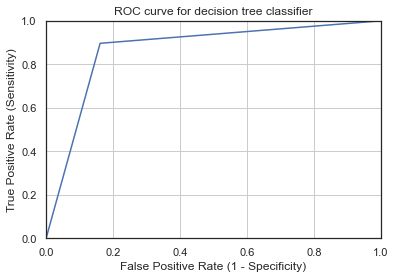

In [185]:
#ROC - summarizes the performance of the model at different threshold values
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred1)

plt.plot(fpr1, tpr1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for decision tree classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [186]:
def evaluate_threshold(threshold1):
    print('Sensitivity:', tpr1[thresholds1 > threshold1][-1])
    print('Specificity:', 1 - fpr1[thresholds1 > threshold1][-1])
evaluate_threshold(0.5)

Sensitivity: 0.896551724137931
Specificity: 0.8387096774193549


In [386]:
#AUC - area under the curve - the best is AUC=1
print('AUC of decision tree model:',round(metrics.roc_auc_score(y_test, y_pred1),2)*100,'%')

AUC of decision tree model: 87.0 %


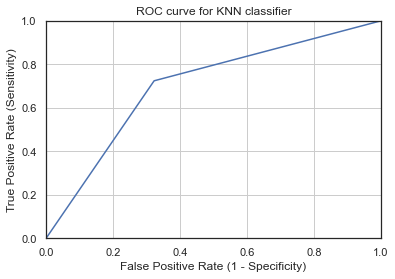

In [106]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred2)

plt.plot(fpr2, tpr2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for KNN classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [107]:
def evaluate_threshold(threshold2):
    print('Sensitivity:', tpr2[thresholds2 > threshold2][-1])
    print('Specificity:', 1 - fpr2[thresholds2 > threshold2][-1])
evaluate_threshold(0.5)

Sensitivity: 0.7241379310344828
Specificity: 0.6774193548387097


In [108]:
#AUC - area under the curve
print('AUC of decision tree model:',round(metrics.roc_auc_score(y_test, y_pred2),2)*100,'%')

AUC of decision tree model: 70.0 %


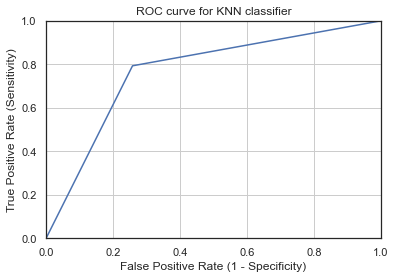

In [109]:
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test, y_pred3)

plt.plot(fpr3, tpr3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for KNN classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [110]:
def evaluate_threshold(threshold3):
    print('Sensitivity:', tpr3[thresholds3 > threshold3][-1])
    print('Specificity:', 1 - fpr3[thresholds3 > threshold3][-1])
evaluate_threshold(0.5)

Sensitivity: 0.7931034482758621
Specificity: 0.7419354838709677


In [111]:
#AUC - area under the curve
print('AUC of decision tree model:',round(metrics.roc_auc_score(y_test, y_pred3),2)*100,'%')

AUC of decision tree model: 77.0 %


### Exercise 3

##### Train models with different parameters

#### Decision tree classifier

In [176]:
model6 = DecisionTreeClassifier(criterion='entropy', splitter='best')
model6 = model6.fit(X_train,y_train)
y_pred6 = model6.predict(X_test)

#### K-Nearest Neighbors classifier

In [403]:
model7 = KNeighborsClassifier(n_neighbors=1, weights='distance',leaf_size=50)
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)

#### Support vector machine classifier

In [209]:
model8 = svm.SVC(kernel='linear', coef0=1.0, random_state=42)
model8.fit(X_train, y_train)
y_pred8 = model8.predict(X_test)

#### Logistic classifier

In [234]:
model9 = LogisticRegression(class_weight='balanced',solver= 'newton-cg', multi_class='multinomial', random_state=42)
model9.fit(X_train,y_train)
y_pred9 = model9.predict(X_test)

#### XGBoost classifier

In [293]:
#looking for the best parameters
#https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
model10 = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

model10.fit(X_train,y_train)
print("Best parameters:", model10.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}


In [295]:
model10 = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.01, max_depth= 3, n_estimators=1000)
model10.fit(X_train,y_train)
predictions = model10.predict(X_test)
y_pred10 = [round(value) for value in predictions]

### Exercise 4

##### Compare the models with train/test approximation and cross-validation

In [404]:
#comparing f1_scores
f6 = f1_score(y_test, y_pred6)
f7 = f1_score(y_test, y_pred7)
f8 = f1_score(y_test, y_pred8)
f9 = f1_score(y_test, y_pred9)
f10 = f1_score(y_test, y_pred10)

d1 = {'DT': f1, 'KNN': f2, 'SVM': f3, 'Logistic': f4, 'XGBoost': f5}
class1 = pd.Series(data=d1, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

d2 = {'DT': f6, 'KNN': f7, 'SVM': f8, 'Logistic': f9, 'XGBoost': f10}
class2 = pd.Series(data=d2, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

df_class = pd.DataFrame({'First F1_score':class1, 'Second F1_score':class2})
df_class

,First F1_score,Second F1_score
DT,0.866667,0.935484
KNN,0.700000,0.745763
SVM,0.766667,0.900000
Logistic,0.827586,0.885246
XGBoost,0.935484,0.935484


Tuning changes:
- Decision Tree: improvement with splitter='best'
- KNN: improvement with lower number of neighbors, changing leaf size
- SVM: improvement with linear kernel, default was rbf
- LC: improvement with multi_class='multinomial'
- XGB: no improvement, the model was already very accurate

In [405]:
#Cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

scores1 = cross_val_score(model1, X_test, y_test, cv=cv)
scores2 = cross_val_score(model2, X_test, y_test, cv=cv)
scores3 = cross_val_score(model3, X_test, y_test, cv=cv)
scores4 = cross_val_score(model4, X_test, y_test, cv=cv)
scores5 = cross_val_score(model5, X_test, y_test, cv=cv)

print(" Decision tree classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))
print(" KNN classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))
print(" SVM classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores3.mean(), scores3.std()))
print(" Logistic classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores4.mean(), scores4.std()))
print(" XGBoost classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores5.mean(), scores5.std()))

 Decision tree classifier has 0.87 accuracy with a standard deviation of 0.07
 KNN classifier has 0.65 accuracy with a standard deviation of 0.06
 SVM classifier has 0.72 accuracy with a standard deviation of 0.08
 Logistic classifier has 0.88 accuracy with a standard deviation of 0.11
 XGBoost classifier has 0.93 accuracy with a standard deviation of 0.13


Conclusion:
- The best classifier would be Decision Tree and XGBoost classifier.
- The Stratified K-Fold is generelly better for classification problems, another one is ShuffleSplit used for regressions.

## Level 2

### Exercise 5

##### Feature-engineering process to get better prediction.

How can I deal with the outliers?

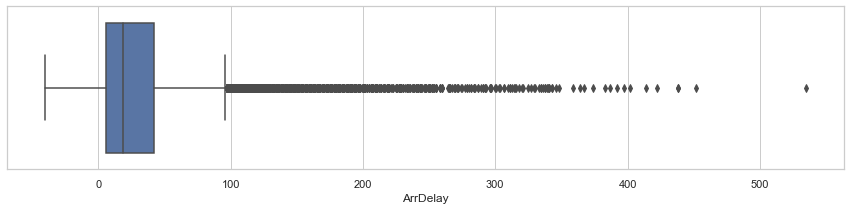

In [339]:
a = df_flights['ArrDelay']
plt.figure(figsize=(15,3))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(a)

In [340]:
#eliminate outliers from Q1 and Q3 - 0.25 0.75
Q1 = a.quantile(q=0.25)
Q3 = a.quantile(q=0.75)
print(Q1, Q3)

6.0 42.0


In [341]:
df_mod = df_flights[(df_flights['ArrDelay'] >= 6) & (df_flights['ArrDelay'] <= 42)]
df_mod.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
1,2008,1,3,4,1530,65.0,24.0,36.0,4.0,8.0,1
2,2008,1,3,4,1240,65.0,33.0,30.0,3.0,18.0,1
6,2008,1,3,4,1120,65.0,31.0,12.0,22.0,19.0,1


In [342]:
#stratified random sample - take 50 flights with delay and 50 with no delay
group1 = df_mod[df_mod['Label'] == 0]
group2 = df_mod[df_mod['Label'] == 1]
flights_df1 = group1.sample(n = 100)
flights_df2 = group2.sample(n = 100)
df_flights_sample2 = flights_df1.append((flights_df2),ignore_index = True)
df_flights_sample2.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
0,2008,12,17,3,1620,275.0,31.253548,6.0,5.793312,6.0,0
1,2008,2,13,3,1845,85.0,31.253548,8.0,5.793312,5.0,0
2,2008,6,17,2,1210,300.0,31.253548,38.0,5.793312,8.0,0


In [343]:
X = df_flights_sample2.drop('Label',axis=1)
y = df_flights_sample2['Label']
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [344]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(140, 10) (140,) (60, 10) (60,)


In [345]:
#scaling the values
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Decision tree classifier

In [346]:
model11 = DecisionTreeClassifier(criterion='entropy', splitter='best')
model11 = model11.fit(X_train,y_train)
y_pred11 = model11.predict(X_test)

#### K-Nearest Neighbors classifier

In [347]:
model12 = KNeighborsClassifier(n_neighbors=3, weights='distance',leaf_size=40)
model12.fit(X_train, y_train)
y_pred12 = model12.predict(X_test)

#### Support vector machine classifier

In [348]:
model13 = svm.SVC(kernel='linear', coef0=1.0, random_state=42)
model13.fit(X_train, y_train)
y_pred13 = model13.predict(X_test)

#### Logistic classifier

In [349]:
model14 = LogisticRegression(class_weight='balanced',solver= 'newton-cg', multi_class='multinomial', random_state=42)
model14.fit(X_train,y_train)
y_pred14 = model14.predict(X_test)

#### XGBoost classifier

In [350]:
data_dmatrix = xgb.DMatrix(data=X_test,label=y_test)
model15 = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.01, max_depth= 3, n_estimators=1000)
model15.fit(X_train,y_train)
predictions = model15.predict(X_test)
y_pred15 = [round(value) for value in predictions]

In [406]:
#comparing f1_scores
f11 = f1_score(y_test, y_pred11)
f12 = f1_score(y_test, y_pred12)
f13 = f1_score(y_test, y_pred13)
f14 = f1_score(y_test, y_pred14)
f15 = f1_score(y_test, y_pred15)

d1 = {'DT': f1, 'KNN': f2, 'SVM': f3, 'Logistic': f4, 'XGBoost': f5}
class1 = pd.Series(data=d1, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d2 = {'DT': f6, 'KNN': f7, 'SVM': f8, 'Logistic': f9, 'XGBoost': f10}
class2 = pd.Series(data=d2, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d3 = {'DT': f11, 'KNN': f12, 'SVM': f13, 'Logistic': f14, 'XGBoost': f15}
class3 = pd.Series(data=d3, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

df_class = pd.DataFrame({'First F1_score':class1, 'Second F1_score':class2, 'Third F1_score':class3})
df_class

,First F1_score,Second F1_score,Third F1_score
DT,0.866667,0.935484,1.000000
KNN,0.700000,0.745763,0.800000
SVM,0.766667,0.900000,0.763636
Logistic,0.827586,0.885246,0.827586
XGBoost,0.935484,0.935484,1.000000


Conclusions:
- Tuning of the initial models improved the performance
- The feature engeneering also improved Decision Tree and XGBoost classifier.

## Level 3

### Exercise 6

##### Prediction without variable DepDelay.

In [353]:
df_flights2 = df_flights.copy()
df_flights2.drop('DepDelay',axis=1, inplace=True)
df_flights2.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,TaxiIn,TaxiOut,Label
0,2008,1,3,4,1940,250.0,57.0,3.0,7.0,1
1,2008,1,3,4,1530,65.0,24.0,4.0,8.0,1
2,2008,1,3,4,1240,65.0,33.0,3.0,18.0,1


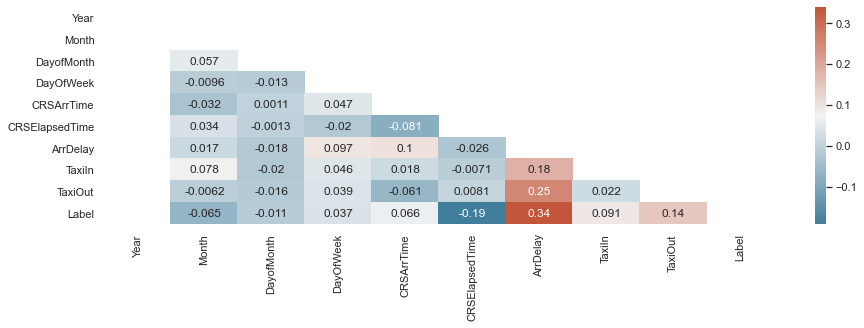

In [354]:
#Correlation matrix
fig,ax = plt.subplots(figsize=(15,4))
corr = df_flights2.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

In [355]:
#stratified random sample - take 50 flights with delay and 50 with no delay
group1 = df_flights2[df_flights2['Label'] == 0]
group2 = df_flights2[df_flights2['Label'] == 1]
flights_df1 = group1.sample(n = 100)
flights_df2 = group2.sample(n = 100)
df_flights_sample3 = flights_df1.append((flights_df2),ignore_index = True)
df_flights_sample3.head(3)

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,TaxiIn,TaxiOut,Label
0,2008,10,19,7,1345,315.0,-4.0,6.0,7.0,0
1,2008,8,1,5,1710,150.0,0.0,6.0,16.0,0
2,2008,8,19,2,1555,90.0,-3.0,7.0,7.0,0


In [356]:
X = df_flights_sample3.drop('Label',axis=1)
y = df_flights_sample3['Label']
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [357]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(140, 9) (140,) (60, 9) (60,)


In [358]:
#scaling the values
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Decision tree classifier

In [359]:
model16 = DecisionTreeClassifier()
model16 = model16.fit(X_train,y_train)
y_pred16 = model16.predict(X_test)

#### K-Nearest Neighbors classifier

In [401]:
model17 = KNeighborsClassifier(n_neighbors=1, weights='distance',leaf_size=50)
model17.fit(X_train, y_train)
y_pred17 = model17.predict(X_test)

#### Support vector machine classifier

In [397]:
model18 = svm.SVC(kernel='linear', coef0=1.0, random_state=42)
model18.fit(X_train, y_train)
y_pred18 = model18.predict(X_test)

#### Logistic classifier

In [362]:
model19 = LogisticRegression()
model19.fit(X_train,y_train)
y_pred19 = model19.predict(X_test)

#### XGBoost classifier

In [393]:
model20 = xgb.XGBRegressor()
model20.fit(X_train,y_train)
predictions = model20.predict(X_test)
y_pred20 = [round(value) for value in predictions]

In [407]:
#comparing f1_scores
f16 = f1_score(y_test, y_pred16)
f17 = f1_score(y_test, y_pred17)
f18 = f1_score(y_test, y_pred18)
f19 = f1_score(y_test, y_pred19)
f20 = f1_score(y_test, y_pred20)

d1 = {'DT': f1, 'KNN': f2, 'SVM': f3, 'Logistic': f4, 'XGBoost': f5}
class1 = pd.Series(data=d1, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d2 = {'DT': f6, 'KNN': f7, 'SVM': f8, 'Logistic': f9, 'XGBoost': f10}
class2 = pd.Series(data=d2, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d3 = {'DT': f11, 'KNN': f12, 'SVM': f13, 'Logistic': f14, 'XGBoost': f15}
class3 = pd.Series(data=d3, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d4 = {'DT': f16, 'KNN': f17, 'SVM': f18, 'Logistic': f19, 'XGBoost': f20}
class4 = pd.Series(data=d4, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

df_class = pd.DataFrame({'First F1_score':class1, 'Second F1_score':class2,
                         'Third F1_score':class3,'Fourth F1_score':class4, })
df_class

,First F1_score,Second F1_score,Third F1_score,Fourth F1_score
DT,0.866667,0.935484,1.000000,0.982456
KNN,0.700000,0.745763,0.800000,0.745763
SVM,0.766667,0.900000,0.763636,0.947368
Logistic,0.827586,0.885246,0.827586,0.947368
XGBoost,0.935484,0.935484,1.000000,1.000000


Conclusion:
- Classification without DepDelay are sowing better results. That means that if we work with values with are not strongly correlated we can perform better classification algorithms.
- Probabely the best solution of classification for the dataset would be Decision Tree and XGBoost.

In [410]:
#exporting requirements
conda list -e > requirements.txt


Note: you may need to restart the kernel to use updated packages.


#### Notes
* Freeze
    - https://pip.pypa.io/en/stable/cli/pip_freeze/
* Decision Tree
    - https://www.datacamp.com/community/tutorials/decision-tree-classification-python
* How to evaluate
    - https://towardsdatascience.com/how-to-best-evaluate-a-classification-model-2edb12bcc587
    - https://www.ritchieng.com/machine-learning-evaluate-classification-model/
    - https://towardsdatascience.com/hackcvilleds-4636c6c1ba53
* K-Nearest Neighbors
    - https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
* Logistic Regression classifier
    - https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
    - https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
* Support vector machine
    - https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
* XGBoost
    - https://www.datacamp.com/community/tutorials/xgboost-in-python
* Cross-validation
    - https://scikit-learn.org/stable/modules/cross_validation.html
    - https://machinelearningmastery.com/k-fold-cross-validation/